## Assignment 2 For Clustering: Sessa Empirical Estimator
---
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Create a callable function in each step. Check if these callable function has the same result (and insights) with your Jupyter Notebook.

## 1. Import Required Libraries
---

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

## 2. Load and Prepare Data
---

In [10]:
def prepare_data(df):
    df = df.rename(columns={
        "PATIENT_ID": "pnr",
        "DATE": "eksd",
        "PERDAY": "perday",
        "CATEGORY": "ATC",
        "DURATION": "dur_original"
    })
    df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")  # Assuming 'mm/dd/yyyy' format
    return df

## 3. Define See Function
---

In [9]:
def See(df, med_code):
    # Filter medication
    C09CA01 = df[df["ATC"] == med_code].copy()
    
    # Sort and compute event intervals
    C09CA01 = C09CA01.sort_values(by=["pnr", "eksd"])
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    C09CA01 = C09CA01.dropna().reset_index(drop=True)

    # Sample one record per patient
    np.random.seed(123)
    Drug_see_p1 = C09CA01.groupby("pnr").sample(n=1, random_state=123).reset_index(drop=True)

    # ECDF analysis (filtering values below the 80th percentile)
    quantile_80 = Drug_see_p1["event_interval"].quantile(0.8)
    dfper = Drug_see_p1[Drug_see_p1["event_interval"] <= quantile_80]

    # Log-transform and scale data for clustering
    log_intervals = np.log(dfper["event_interval"])
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(log_intervals.values.reshape(-1, 1))

    # Determine optimal clusters using silhouette method
    def find_optimal_k(data):
        best_k, best_score = 2, -1
        for k in range(2, 10):  # Testing k from 2 to 10
            kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10).fit(data)
            score = silhouette_score(data, kmeans.labels_)
            if score > best_score:
                best_k, best_score = k, score
        return best_k
    
    max_cluster = find_optimal_k(scaled_data)

    # Apply K-Means Clustering
    np.random.seed(1234)
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)
    dfper["cluster"] = kmeans.fit_predict(scaled_data)

    # Create cluster ranges
    cluster_ranges = dfper.groupby("cluster")["event_interval"].agg(
        Minimum=lambda x: np.exp(min(np.log(x))),
        Maximum=lambda x: np.exp(max(np.log(x))),
        Median=lambda x: np.exp(np.median(np.log(x)))
    ).reset_index().sort_values(by="Median")

    # Merge cluster information
    dfper["log_interval"] = np.log(dfper["event_interval"])
    dfper["scaled"] = scaler.transform(dfper[["log_interval"]])
    dfper = dfper.merge(cluster_ranges, on="cluster", how="left")

    # Handling NA values
    main_cluster = dfper["cluster"].value_counts().idxmax()
    main_median = cluster_ranges.loc[cluster_ranges["cluster"] == main_cluster, "Median"].values[0]

    # Final data merge
    Drug_see_p0 = C09CA01.merge(
        dfper[["pnr", "Median", "cluster"]],
        on="pnr",
        how="left"
    )

    Drug_see_p0["Median"] = Drug_see_p0["Median"].fillna(main_median)
    Drug_see_p0["cluster"] = Drug_see_p0["cluster"].fillna(main_cluster)

    return Drug_see_p0

## 4.  Define see_assumption Function
---

In [8]:
def see_assumption(med_data):
    med_data = med_data.sort_values(by=["pnr", "eksd"])
    med_data["prev_eksd"] = med_data.groupby("pnr")["eksd"].shift(1)
    med_data["p_number"] = med_data.groupby("pnr").cumcount() + 1
    med_data["Duration"] = (med_data["eksd"] - med_data["prev_eksd"]).dt.days

    med_data = med_data[med_data["p_number"] >= 2]

    overall_median = med_data["Duration"].median()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=med_data["p_number"].astype(str), y=med_data["Duration"])
    plt.axhline(y=overall_median, linestyle="dashed", color="red")
    plt.xlabel("Prescription Sequence Number")
    plt.ylabel("Duration (days)")
    plt.title("Prescription Interval Analysis")
    plt.show()

## 5.  Execute Analysis
---

C:\Users\Charles\AppData\Local\Temp\ipykernel_15056\1501617631.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfper["cluster"] = kmeans.fit_predict(scaled_data)
C:\Users\Charles\AppData\Local\Temp\ipykernel_15056\1501617631.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfper["log_interval"] = np.log(dfper["event_interval"])
C:\Users\Charles\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted 

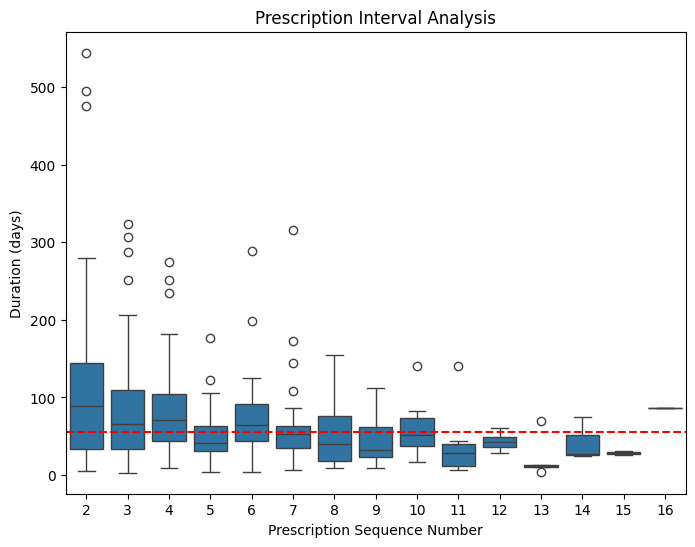

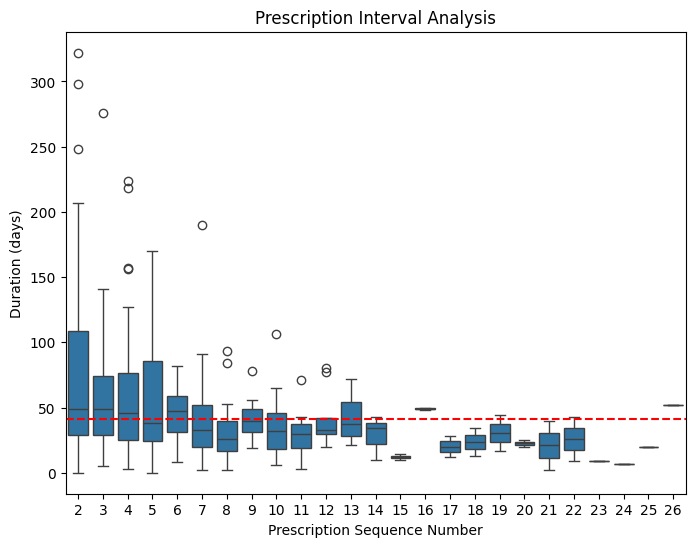

In [14]:
df = pd.read_csv("../csv/med_events.csv")

# Prepare data
df = prepare_data(df)

# Perform analysis for different medications
medA = See(df, "medA")
medB = See(df, "medB")

# Generate plots
see_assumption(medA)
see_assumption(medB)